<a href="https://colab.research.google.com/github/KingYuanSun/Individual-Projects-NLP/blob/master/Sentiment_Analysis_StockTrendPrediction_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT with Sentiment analysis¶
In this notebook I used a pretrained version of BERT avaliable as a huggingface transformed to classify the sentiment of news articles about Bitcoin and Tesla, and applied an LSTM to predict the stock returns

Sources
https://towardsdatascience.com/fine-tuning-bert-with-keras-and-tf-module-ed24ea91cff2

Bert for dummies: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
Bert for long texts: https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d
googles notebook: https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb
strong.io: https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
strong.io notebook : https://github.com/strongio/keras-bert
https://keras.io/layers/writing-your-own-keras-layers/

In [1]:
!pip install utils
!pip install bert-for-tf2
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install nltk
!pip install yfinance
!pip install news-please
!pip install google
!pip install transformers

     |████████████████████████████████| 40kB 3.3MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-cp36-none-any.whl size=30315 sha256=bbe55d7fe9a2454191bc24ed44079c409085634ff006b78aa344329ed0249ab9
  Stored in directory: /root/.cache/pip/wheels/2e/70/a2/be357037dd2cbdcaeb0add1fdf083be6a600ca65ee1f68751c
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=dc94d3918bb08994d2d8bb96fa5ce80b64d3362cb5c04595d5828aea855a95b7
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=7fa0c6755b28a5bebaacf37ea18d1f5a8561509a4f9b5d2f48677edc5c458dd6
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha

In [2]:
##utils.py

import pandas as pd, numpy as np
try:
	import bert
except:
	print("bert-for-tf2 not installed")

# transforms sentences to ids, masks and segment ids prepared to feed bert
def convert_sentence_to_features(sentence, tokenizer, max_seq_len):
    tokens = ['[CLS]']
    tokens.extend(tokenizer.tokenize(sentence))
    if len(tokens) > max_seq_len-1:
        tokens = tokens[:max_seq_len-1]
    tokens.append('[SEP]')
    
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    #Zero Mask till seq_length
    zero_mask = [0] * (max_seq_len-len(tokens))
    input_ids.extend(zero_mask)
    input_mask.extend(zero_mask)
    segment_ids.extend(zero_mask)
    
    return input_ids, input_mask, segment_ids

def convert_sentences_to_features(sentences, tokenizer, max_seq_len=200):
    all_input_ids = []
    all_input_mask = []
    all_segment_ids = []
    
    for sentence in sentences:
        input_ids, input_mask, segment_ids = convert_sentence_to_features(sentence, tokenizer, max_seq_len)
        all_input_ids.append(input_ids)
        all_input_mask.append(input_mask)
        all_segment_ids.append(segment_ids)
    
    return all_input_ids, all_input_mask, all_segment_ids

def generate_data_for_tokenizer(split_text,target_series):
    labels_list = []
    dates = []
    for date, arrays in split_text.itertuples():
        dates.extend([date]* len(arrays))
    for date in dates:
        labels_list.append(target_series.loc[date])
    
    split_text_flat = split_text.values.flatten()
    sentence_list = [sentence for array in split_text_flat for sentence in array]
    
    labels = pd.DataFrame(labels_list, index = dates)
    sentences  = pd.DataFrame(sentence_list, index = dates)
    return sentences, labels

# given an input text and a set of keywords, returns the top_n_terms which contain any of the keywords by frequency of appearance.
def find_new_token_with_custom_keywords(array_of_text, custom_keywords, top_n_terms, extra_tokens):
    
    def contains_keyword(word,keywords):
        for k in keywords:
            if word.find(k) >= 0:
                return True
        return False
    
    def count_frequency(my_list): 
        freq = {} 
        for item in my_list: 
            if (item in freq): 
                freq[item] += 1
            else: 
                freq[item] = 1
        return freq
    
    raw_text = "".join(array_of_text).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")
    raw_words = raw_text.split(" ")
    matches = []
    for word in raw_words:
        if contains_keyword(word.lower(),custom_keywords):
            matches.append(word.lower())
    
    matches_count = count_frequency(matches)
    #sorts the counts
    #matches_dict = {k: v for k, v in sorted(matches_count.items(), key=lambda item: item[1], reverse = True)}
    # selects top n words from the list
    #new_tokens = list(matches_dict)[:top_n_terms]  + extra_tokens
    import operator
    sorted_x = sorted(matches_count.items(), key=operator.itemgetter(1), reverse = True)
    new_tokens = [ tup[0] for tup in sorted_x[:top_n_terms]]  + extra_tokens
    
    print("New tokens to be added: ",new_tokens)
    return new_tokens

# creates bert tokenizer
def create_tokenizer(vocab_file='vocab.txt', do_lower_case=True):
    return bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

# appends extra tokens to the vocab of the tokenizer
def add_new_tokens(new_vocab, tokenizer):
    for i in range(len(new_vocab)):
        new_key = new_vocab[i]
        old_key = "[unused{}]".format(i)
        value = tokenizer.vocab.pop(old_key)
        tokenizer.vocab[new_key] = value
    return tokenizer

# transforms bet output in one continuous series removing the padding
def bert_output_to_one_time_series_per_day(bert_inputs, bert_output, sentences):
    n_sentences = sentences.groupby(sentences.index).count()
    n_tokens = bert_inputs["input_mask"][:].sum(axis = 1)
    mask_out = [bert_output[1][counter,:length,:] for length, counter in zip(n_tokens,range(len(n_tokens)))]
    
    articles_per_day = []
    acc = 0
    for n in n_sentences.values:
        n = n[0]
        concat_articles = np.array(mask_out[acc:acc + n])
        flattened = []
        for sentence in concat_articles:
            for token in sentence:
                flattened.append(token)
        flattened = np.array(flattened)
        #flattened = np.array([token for token in sentence for sentence in concat_articles])
        articles_per_day.append(flattened)
        acc += n
    return np.array(articles_per_day)

# prepares_labels
def label_transformer(prices, mode = "returns", shift = 5, index = None, standarized = False):
    prices = pd.DataFrame(prices)
    prices.columns = ["today"]
    if index is not None:
        prices = prices[index]
    prices["tomorrow"] = prices.shift(1)
    prices["returns"] = prices["today"].pct_change()
    prices["diff"] = prices["today"] - prices["tomorrow"]
    def standard(df):
        return (df - df.mean())/df.std()
    output = prices[mode].shift(shift).dropna()
    return output if not standarized else standard(output)

# computes and returns intersection among series
def series_intersection(a,b):
    a.index = pd.DatetimeIndex(a.index)
    b.index = pd.DatetimeIndex(b.index)
    intersection = pd.DatetimeIndex([value for value in a.index if value in b.index])
    return a.loc[intersection], b.loc[intersection]



def rolling_window_bert_2nd_dim(a, window):
    shape = (a.shape[0] - window + 1, window, a.shape[1])
    strides = (a.strides[0], a.strides[1]*a.shape[1], a.strides[1])
    #print(shape, strides)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


def dummy():
	return "dah"

In [3]:
from tensorflow import keras
import numpy as np
import time



class Classifier_INCEPTION:

    def __init__(self, output_directory, input_shape, nb_classes, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=41, nb_epochs=1500):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'model_init.hdf5')

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = keras.layers.Concatenate(axis=2)(conv_list)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        x = keras.layers.Add()([shortcut_y, out_tensor])
        x = keras.layers.Activation('relu')(x)
        return x

    def build_layer_structure(self, input_tensor):
        x = input_tensor
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_tensor, x)
                input_res = x

        gap_layer = keras.layers.GlobalAveragePooling1D()(x)


        return  gap_layer


    def build_model(self, input_shape, nb_classes):
        input_layer = keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = keras.layers.GlobalAveragePooling1D()(x)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50,
                                                      min_lr=0.0001)

        file_path = self.output_directory + 'best_model.hdf5'

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)

        self.callbacks = [reduce_lr, model_checkpoint]

        return model

    def fit(self, x_train, y_train, x_val, y_val, y_true, plot_test_acc=False):

        # x_val and y_val are only used to monitor the test loss and NOT for training

        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        start_time = time.time()

        if plot_test_acc:

            hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=self.nb_epochs,
                                  verbose=self.verbose, validation_data=(x_val, y_val), callbacks=self.callbacks)
        else:

            hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=self.nb_epochs,
                                  verbose=self.verbose, callbacks=self.callbacks)

        duration = time.time() - start_time

        self.model.save(self.output_directory + 'last_model.hdf5')

        y_pred = self.predict(x_val, y_true, x_train, y_train, y_val)

        # save predictions
        np.save(self.output_directory + 'y_pred.npy', y_pred)

        # convert the predicted from binary to integer
        y_pred = np.argmax(y_pred, axis=1)

        keras.backend.clear_session()

        return hist

    def predict(self, x_test, y_true, x_train, y_train, y_test):
        start_time = time.time()
        model_path = self.output_directory + 'best_model.hdf5'
        model = keras.models.load_model(model_path)
        y_pred = model.predict(x_test, batch_size=self.batch_size)
        return y_pred

In [4]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# !ls "/content/drive/My Drive"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import tensorflow as tf
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from utils import *

import importlib
import utils
importlib.reload(utils)
from utils import *

import yfinance as yf

start = "2019-01-01"
end   = "2020-03-20"

bitcoin = False
if not bitcoin:   
    stocks = ["TSLA"]
    keywords = {"TSLA": ["Tesla", "Elon Musk"]}
else:    
    stocks = ["BTC-USD"]
    keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

df_financial = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
prices = df_financial["Close"]
prices = pd.DataFrame(data = prices, index = pd.date_range(start,end)).fillna(method = "bfill")

df_bitcoin = pd.read_csv("/content/drive/My Drive/ColabData/articles_Bitcoin-Cryptocurrency_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df_tesla = pd.read_csv("/content/drive/My Drive/ColabData/articles_Tesla-Elon_Musk_start=2019-01-01_end=2020-12-31.csv", index_col = 0)
df = df_bitcoin if bitcoin else df_tesla

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoModelForSequenceClassification, TFBertForSequenceClassification 

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Split sentences

In [6]:
main_text = False
if main_text:
    # main_text
    text = df.maintext #pd.DataFrame(df.maintext.values, index = df["date_google"]).dropna()
    text.index = df["date_google"]
else:    
    # titles and descriptions
    titles = df.title
    titles.index = df["date_google"]
    descriptions = df.description
    descriptions.index = df["date_google"]
    text = pd.concat([titles,descriptions]).sort_index().dropna()
    
print(text.values[0])

import nltk.data
nltk.download('punkt')
split_sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

split_sentences = text.apply(split_sentence_tokenizer.tokenize)
split_sentences = split_sentences.groupby(split_sentences.index).sum()
split_sentences = pd.DataFrame(split_sentences)

df_ret = label_transformer(prices.copy(), shift = 1)

split_sentences, df_ret = series_intersection(split_sentences, df_ret)
raw_sentences, raw_labels = generate_data_for_tokenizer(split_sentences,df_ret)

lengths = raw_sentences.apply(lambda x: len(x[0].split()), axis = 1)
sentences = raw_sentences[(lengths > 10) & (lengths < 120)] #filter short and long sentences

labels = raw_labels[(lengths > 10) & (lengths < 120)]

keywords_bitcoin = ["crypto", "BTC", "bitcoin", "blockchain"]
keywords_tesla =   ["tesla", "Elon", "Musk", "TSLA", "Tesla"]
keys = keywords_bitcoin if bitcoin else keywords_tesla
raw_text = "".join(text.values).replace(".com","-com").replace(".", "").replace(",", "").replace("\n", " ").replace("-com",".com")
new_tokens = find_new_token_with_custom_keywords(raw_text, keys , 6, [])
# new_tokens = new_tokens.append('tesla\'s')

print (new_tokens)
print (sentences[0])
print (sentences[0][19])

print (sentences.dtypes)
savedsentences = sentences

res = [sub.replace('Tesla\'s', 'tesla').replace('Tesla’s', 'tesla').replace('tesla\'s', 'tesla').replace('tesla’s', 'tesla').replace('Teslas', 'tesla').replace('teslaelon', 'tesla').replace('musktesla', 'tesla') for sub in sentences[0]] 

# tesla’s Teslas

sentences = pd.Series(res) 
print (sentences[19])
print (sentences[103])
# sentences = []
# sentences.append(res)
# print (sentences[0][19])
# print (res[19])

Conor McGregor compared himself to Elon Musk in fiery exchange with Floyd Mayweather's manager
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
New tokens to be added:  ['tesla', "tesla's", 'tesla’s', 'teslas', 'teslaelon', 'musktesla']
['tesla', "tesla's", 'tesla’s', 'teslas', 'teslaelon', 'musktesla']
2019-01-03    Tesla CEO Elon Musk doubled down on criticism ...
2019-01-03    It’s a counterintuitive result to mention toda...
2019-01-03    But over a century of research on work environ...
2019-01-03    Elon Musk tweeted that Singapore has been unwe...
2019-01-03    From a Japanese mathematician to Elon Musk, he...
                                    ...                        
2020-03-19    Tesla Cybertruck Gigafactory: Oklahoma pulls o...
2020-03-19    NYC mayor asks Elon Musk to manufacture ventil...
2020-03-19    Elon Musk downplays coronavirus as Tesla facto...
2020-03-19    Elon Musk took to Twitter yesterday to claim h..

In [7]:
#model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = TFAutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", from_pt=True)
tokenizer.add_tokens(new_tokens)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


5

In [8]:
example = "Bitcoin futures are trading below the cryptocurrency's spot price"
print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids]) 
print("    1 star     2 stars     3 stars     4 stars     5 stars")
print(output[0])

['bit', '##co', '##in', 'futures', 'are', 'trading', 'below', 'the', 'cry', '##pt', '##oc', '##urre', '##ncy', "'", 's', 'spot', 'price']
[101, 16464, 10805, 10262, 42272, 10320, 34948, 16934, 10103, 29917, 15903, 20731, 46642, 19771, 112, 161, 24311, 16993, 102]
    1 star     2 stars     3 stars     4 stars     5 stars
[[ 1.1589037   0.64755297  0.23367813 -0.68713945 -1.1347755 ]]


In [9]:
example = "I am so disappointed with this product"
print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids])
print("    1 star     2 stars    3 stars    4 stars    5 stars")
print(output[0])

['i', 'am', 'so', 'disa', '##ppo', '##inted', 'with', 'this', 'product']
[101, 151, 10345, 10297, 31021, 54894, 83912, 10171, 10372, 20058, 102]
    1 star     2 stars    3 stars    4 stars    5 stars
[[ 3.3838348   2.860919    0.64698035 -2.6131778  -3.514816  ]]


In [10]:
example = "Elon Musk's 'Blastar' would be a perfect addition to tesla Easter Eggs"


print(tokenizer.tokenize(example))
example_ids = tokenizer.encode(example)
print(example_ids)
output = model.predict([example_ids])
print("    1 star     2 stars    3 stars    4 stars    5 stars")
print(output[0])

['elo', '##n', 'mus', '##k', "'", 's', "'", 'blast', '##ar', "'", 'would', 'be', 'a', 'perfect', 'addition', 'to', 'tesla', 'easter', 'eggs']
[101, 21834, 10115, 23139, 10167, 112, 161, 112, 47732, 10370, 112, 11008, 10346, 143, 23021, 15000, 10114, 51571, 58776, 48540, 102]
    1 star     2 stars    3 stars    4 stars    5 stars
[[-1.4823589  -0.8959735   0.41832682  1.1279128   0.57270634]]


In [11]:
sentences = sentences.apply(lambda x : tokenizer.tokenize(x))

In [12]:
encoded_sentences = sentences.apply(lambda x : tokenizer.encode(x))
print (sentences)
print (encoded_sentences)
print (encoded_sentences[0])
print (encoded_sentences[1])
encoded_sentences.shape

0       [tesla, ceo, elo, ##n, mus, ##k, double, ##d, ...
1       [it, [UNK], s, a, counter, ##int, ##uit, ##ive...
2       [but, over, a, century, of, research, on, work...
3       [elo, ##n, mus, ##k, twee, ##ted, that, singap...
4       [from, a, japanese, math, ##ema, ##tician, to,...
                              ...                        
3181    [tesla, cyber, ##tru, ##ck, gi, ##ga, ##fa, ##...
3182    [nyc, mayor, asks, elo, ##n, mus, ##k, to, man...
3183    [elo, ##n, mus, ##k, down, ##play, ##s, corona...
3184    [elo, ##n, mus, ##k, took, to, twitter, yester...
3185    [the, need, is, clear, ,, let, ', s, hope, he,...
Length: 3186, dtype: object
0       [101, 51571, 23693, 21834, 10115, 23139, 10167...
1       [101, 10197, 100, 161, 143, 32964, 16790, 1754...
2       [101, 10502, 10323, 143, 11516, 10108, 11865, ...
3       [101, 21834, 10115, 23139, 10167, 12915, 11894...
4       [101, 10195, 143, 14201, 33508, 17291, 95605, ...
                              ...           

(3186,)

In [13]:
# if we have "tesla's", we failed

# print (encoded_sentences[0])
# print (model.predict([encoded_sentences[0]]))
# print (model.predict([encoded_sentences[0]])[0])

# print (sentences[0][3])
# print (sentences[0][4])
# print (sentences[0][5])
# print (sentences[0][6])
# print (sentences[0][7])
# print (sentences[0][9])
# print (sentences[0][10])
# print (sentences[0][16])
# print (sentences[0][17])
# print (sentences[0][18])
# print (sentences[0][19])
# print (sentences[0][20])

# print (sentences[0][18])
# print (encoded_sentences[18])
# print (model.predict([encoded_sentences[18]]))
# print (model.predict([encoded_sentences[18]])[0])

print (sentences[10])
print (encoded_sentences[10])
print (model.predict(encoded_sentences[10]))
print (model.predict([encoded_sentences[10]])[0])

print (sentences[19])
print (encoded_sentences[19])
print (model.predict([encoded_sentences[19]]))
print (model.predict([encoded_sentences[19]])[0])

# for i in range(1, len(encoded_sentences)): 

#     print (i)
#     print (sentences[i])
#     print(encoded_sentences[i]) 
#     output = model.predict([encoded_sentences[i]])[0]
#     print (output)




['investors', 'appeared', 'to', 'be', 'focusing', 'more', 'on', 'potential', 'road', '##bl', '##ock', '##s', ',', 'including', 'a', 'flood', 'of', 'new', 'competition', 'and', 'the', 'phase', '-', 'out', 'of', 'the', 'federal', 'tax', 'credits', 'that', 'offs', '##et', 'the', 'cost', 'of', 'tesla', 'battery', '-', 'electric', 'vehicles', '.']
[101, 67446, 14889, 10114, 10346, 67493, 10772, 10125, 21570, 11925, 31809, 21906, 10107, 117, 11371, 143, 40241, 10108, 10246, 14262, 10110, 10103, 17324, 118, 10871, 10108, 10103, 12501, 22389, 33896, 10203, 47117, 10337, 10103, 18153, 10108, 51571, 34794, 118, 15988, 25327, 119, 102]
(array([[ 2.10614607e-01,  2.56465971e-01,  1.39126197e-01,
        -2.67221391e-01, -1.65504485e-01],
       [-4.38402593e-01,  5.69914699e-01,  7.56412327e-01,
         2.80109681e-02, -6.12573624e-01],
       [ 1.57692760e-01,  2.46165231e-01,  1.76105484e-01,
        -2.54177332e-01, -1.54445440e-01],
       [ 8.45661685e-02,  2.18767419e-01,  1.93011448e-01,
 

In [14]:
predictions = encoded_sentences.apply(lambda x : model.predict([x])[0])



In [15]:
print (predictions)
print (predictions[0])
print (predictions[1][0])

rows_list = []
for i in range(len(predictions)): 

        rows_list.append(predictions[i][0])

predictions_2 = pd.DataFrame(rows_list) 
predictions_2.set_index(savedsentences.index, inplace=True)
print (predictions_2)


0       [[1.313773, 0.82469416, 0.2615031, -0.60927576...
1       [[0.71614033, 0.46309748, 0.0077712517, -0.315...
2       [[0.3843228, 1.4005018, 1.2825804, -0.5022784,...
3       [[1.3809863, 0.67562026, 0.26868835, -0.566656...
4       [[-0.6009042, -0.6274233, -0.03898189, 0.43423...
                              ...                        
3181    [[0.34391722, -0.21345592, -0.26969814, -0.034...
3182    [[-0.72830445, -0.5591403, 0.06366486, 0.58121...
3183    [[0.56310487, 0.35083747, 0.04043995, -0.14236...
3184    [[0.32203028, 0.32927626, 0.3413322, -0.106624...
3185    [[-2.5682075, -1.786495, 0.6368744, 1.6841565,...
Length: 3186, dtype: object
[[ 1.313773    0.82469416  0.2615031  -0.60927576 -1.4050338 ]]
[ 0.71614033  0.46309748  0.00777125 -0.31597674 -0.66248125]
                   0         1         2         3         4
2019-01-03  1.313773  0.824694  0.261503 -0.609276 -1.405034
2019-01-03  0.716140  0.463097  0.007771 -0.315977 -0.662481
2019-01-03  0.384323  1.4

In [16]:


# predictions_2 = predictions.copy().to_frame()
# predictions_2.set_index(savedsentences.index, inplace=True)
# print (predictions_2)


# Here we should get the average stars for each transaction day.

In [17]:
avg_predictions = predictions_2.groupby(predictions_2.index).apply(np.mean)
avg_predictions_array = np.array([a for a in avg_predictions.values])
shape = avg_predictions_array.shape
pd.to_pickle(avg_predictions, "sentiment_predictions_tesla_with_tokens")

In [18]:
avg_predictions.shape


avg_predictions.columns = ['1star', '2star','3star', '4star','5star']

print (avg_predictions)

               1star     2star     3star     4star     5star
2019-01-03  0.275093  0.341758  0.343074 -0.155093 -0.685328
2019-01-04  0.441897  0.313300  0.170157 -0.129865 -0.645471
2019-01-05  0.341846  0.469301  0.497733 -0.122689 -0.968765
2019-01-06 -0.336655 -0.333981  0.117318  0.392818  0.007872
2019-01-07 -0.260595  0.063817  0.328041  0.234532 -0.391939
...              ...       ...       ...       ...       ...
2020-03-15  0.806598  0.464285  0.072859 -0.320151 -0.835586
2020-03-16  0.532214  0.118662  0.047815 -0.141394 -0.477883
2020-03-17  0.730104  0.302730  0.089542 -0.255150 -0.715611
2020-03-18  0.140814  0.144669  0.169886  0.063744 -0.463030
2020-03-19 -0.334883 -0.355477  0.111074  0.395313  0.083074

[434 rows x 5 columns]


# Here I should link the tesla stock data, and its associated date. Using the above features to do the predictions.

In [52]:
import yfinance as yf
tickers = ['TSLA']
ohlc = yf.download(tickers, start="2019-01-03", end="2020-03-20")
print(list(ohlc.columns.values))
#ohlc.head()
ohlc_reversed = ohlc.sort_values(['Date'], ascending=[False])
ohlc_reversed = ohlc_reversed.reindex(columns=['Open', 'High', 'Low', 'Volume','Adj Close', 'Close'])
ohlc_reversed.drop('Adj Close', axis=1, inplace=True)
print (ohlc_reversed)

[*********************100%***********************]  1 of 1 completed
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
                  Open        High         Low    Volume       Close
Date                                                                
2020-03-19  374.700012  452.000000  358.459991  30195500  427.640015
2020-03-18  389.000000  404.859985  350.510010  23786200  361.220001
2020-03-17  440.010010  471.850006  396.000000  23994600  430.200012
2020-03-16  469.500000  494.869995  442.170013  20489500  445.070007
2020-03-13  595.000000  607.570007  502.000000  22640300  546.619995
...                ...         ...         ...       ...         ...
2019-01-09  335.500000  343.500000  331.470001   5432900  338.529999
2019-01-08  341.959991  344.010010  327.019989   7008500  335.350006
2019-01-07  321.720001  336.739990  317.750000   7551200  334.959991
2019-01-04  306.000000  318.000000  302.730011   7394100  317.690002
2019-01-03  307.000000  309.399994  297.380005 

In [53]:
df = ohlc_reversed.merge(avg_predictions, left_index=True, right_index=True)
df = df.reindex(columns=['1star' ,'2star' ,'3star', '4star','5star' ,'Open', 'High', 'Low', 'Volume', 'Close'])

df = df.iloc[70:]
print (df)
df.head()

               1star     2star     3star  ...         Low   Volume       Close
2019-12-05  0.656206  0.251217  0.121821  ...  327.250000  3724600  330.369995
2019-12-04  0.583709  0.238334  0.182248  ...  332.850006  5533000  333.029999
2019-12-03  1.125776  0.389177  0.030051  ...  332.190002  6573700  336.200012
2019-12-02  0.647019  0.392910  0.139035  ...  328.690002  6074500  334.869995
2019-11-29  0.726175  0.507032 -0.054036  ...  327.500000  2465600  329.940002
...              ...       ...       ...  ...         ...      ...         ...
2019-01-09 -0.661772 -0.323006  0.131057  ...  331.470001  5432900  338.529999
2019-01-08 -0.651154 -0.505755  0.085503  ...  327.019989  7008500  335.350006
2019-01-07 -0.260595  0.063817  0.328041  ...  317.750000  7551200  334.959991
2019-01-04  0.441897  0.313300  0.170157  ...  302.730011  7394100  317.690002
2019-01-03  0.275093  0.341758  0.343074  ...  297.380005  6965200  300.359985

[232 rows x 10 columns]


,1star,2star,3star,4star,5star,Open,High,Low,Volume,Close
2019-12-05,0.656206,0.251217,0.121821,-0.164410,-0.660910,332.829987,334.420013,327.250000,3724600,330.369995
2019-12-04,0.583709,0.238334,0.182248,-0.127802,-0.720698,337.750000,337.859985,332.850006,5533000,333.029999
2019-12-03,1.125776,0.389177,0.030051,-0.418614,-0.859133,332.619995,337.910004,332.190002,6573700,336.200012
2019-12-02,0.647019,0.392910,0.139035,-0.274040,-0.769170,329.399994,336.380005,328.690002,6074500,334.869995
2019-11-29,0.726175,0.507032,-0.054036,-0.318549,-0.729484,331.109985,331.260010,327.500000,2465600,329.940002


In [54]:
# #### Only use stock data, no news features.

# df = ohlc_reversed

# print (df)

In [55]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    ## Probably here add another column as the label.
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]

    # print (result)
    # print (row)
    print (train[:, : -1])
    print (train[:, -1][: ,-1]) 

    print (result[int(row) :, -1][ : ,-1]) 

    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features)) 

 

    return [X_train, y_train, X_test, y_test]

def build_model(layers):

    model = Sequential()
    model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(256, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dense(1, activation='linear'))

    start = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    model.summary() 
    print("Compilation Time : ", time.time() - start)
    return model



In [56]:
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

window = 15
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)
# print (X_train)
# print (y_train)
# print (X_test)
# print (y_test)

model = build_model([X_train.shape[2], window, 100, 1])

[[[ 2.75092743e-01  3.41757722e-01  3.43074384e-01 ...  2.97380005e+02
    6.96520000e+06  3.00359985e+02]
  [ 4.41896515e-01  3.13299659e-01  1.70157118e-01 ...  3.02730011e+02
    7.39410000e+06  3.17690002e+02]
  [-2.60595386e-01  6.38170888e-02  3.28041007e-01 ...  3.17750000e+02
    7.55120000e+06  3.34959991e+02]
  ...
  [-8.16304797e-01 -2.70244682e-01  3.22148425e-01 ...  2.95500000e+02
    1.20667000e+07  2.98920013e+02]
  [-2.01203920e-01 -2.06738753e-01  1.40286913e-01 ...  2.81690002e+02
    1.25300000e+07  2.87589996e+02]
  [ 6.07338975e-01  6.35481894e-01  3.28614975e-01 ...  2.79279999e+02
    8.01220000e+06  2.91510010e+02]]

 [[ 4.41896515e-01  3.13299659e-01  1.70157118e-01 ...  3.02730011e+02
    7.39410000e+06  3.17690002e+02]
  [-2.60595386e-01  6.38170888e-02  3.28041007e-01 ...  3.17750000e+02
    7.55120000e+06  3.34959991e+02]
  [-6.51153644e-01 -5.05755154e-01  8.55029511e-02 ...  3.27019989e+02
    7.00850000e+06  3.35350006e+02]
  ...
  [-2.01203920e-01 -2.0

In [57]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=300,
    validation_split=0.1,
    verbose=0)

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.24 MSE (0.49 RMSE)
Test Score: 0.83 MSE (0.91 RMSE)


In [58]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

print (pred)
print (y_test)

[[0.6987092]
 [0.9319732]
 [1.1996032]
 [1.6222528]
 [1.7339274]
 [1.7974082]
 [1.8562844]
 [1.867992 ]
 [1.9434872]
 [2.0126579]
 [2.0185714]
 [1.9971663]
 [2.0214415]
 [1.7545813]
 [1.7815684]
 [1.5296632]
 [1.5417215]
 [1.4315382]
 [1.5414678]
 [1.6359043]
 [1.8413943]
 [1.9591969]]
[1.92678147 1.91941513 2.19521033 2.45922047 2.5063652  2.74061415
 2.88322631 2.77066848 2.86613681 2.94922929 2.88499416 3.16579886
 2.9507022  3.02760632 2.3855571  2.48279238 2.26416003 2.33399275
 2.29421436 2.43947829 2.4786677  2.38526216]


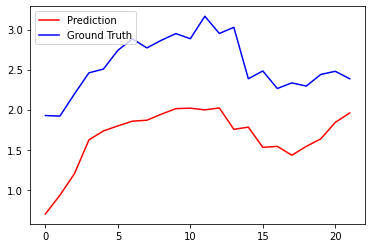

In [59]:
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()